<a href="https://colab.research.google.com/github/marlapinkert/TEWA2/blob/main/07_Second_Level_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 07 -  Second Level Analysis

## Download data and install dependencies

For the group aissgnments, we will provide you with single-subject contrast maps based on which you can perform the second level (or: group level) analysis and report the results. In this notebook, we will work with data included in Nilearn, specifically using the ```fetch_localizer_contrasts()``` function, which qives access to a wide range of functional localizer contrasts (for further infos see [here](https://osf.io/vhtf6)).

In [1]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 42.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from nilearn import datasets, plotting, image
from pprint import pprint

For illustration purposes, we will only the right vs. left button press for a total of 20 participants.

In [4]:
n_subjects = 20

con_left_right = datasets.fetch_localizer_contrasts(["right vs left button press"],
                                                    n_subjects)

Downloaded 212992 of 237851 bytes (89.5%,    0.1s remaining) ...done. (6 seconds, 0 min)


Downloaded 212992 of 239535 bytes (88.9%,    0.1s remaining) ...done. (3 seconds, 0 min)


Downloaded 212992 of 242272 bytes (87.9%,    0.1s remaining) ...done. (3 seconds, 0 min)


Downloaded 212992 of 233739 bytes (91.1%,    0.1s remaining) ...done. (3 seconds, 0 min)


Downloaded 212992 of 218797 bytes (97.3%,    0.0s remaining) ...done. (4 seconds, 0 min)


Downloaded 212992 of 229992 bytes (92.6%,    0.1s remaining) ...done. (4 seconds, 0 min)


Downloaded 212992 of 228038 bytes (93.4%,    0.1s remaining) ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


Downloaded 212992 of 238151 bytes (89.4%,    0.1s remaining) ...done. (3 seconds, 0 min)


Downloaded 212992 of 240700 bytes (88.5%,    0.1s remaining) ...done. (3 seconds, 0 min)


Downloaded 212992 of 240545 bytes (88.5%,    0.1s remaining) ...done. (3 seconds, 0 min)


Downloaded 212992 of 239141 bytes (89.1%,    0.1s remaining) ...done. (3 seconds, 0 min)


Downloaded 212992 of 231462 bytes (92.0%,    0.1s remaining) ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


In [5]:
print(f"data is stored in: {datasets.get_data_dirs()[0]}")

data is stored in: /root/nilearn_data


Now we need to find a way to access the respective contrast maps (one contrast for each subject). The ```glob``` module from the Python standard library can help us here. It provides a nice way to list the contens of given paths:

In [6]:
from glob import glob

cmaps = sorted(
    glob(f"{datasets.get_data_dirs()[0]}/brainomics_localizer/brainomics_data/**/*.nii.gz",
         recursive=True)
)

pprint(cmaps)
print(f"\nThere are {len(cmaps)} contrast maps")

['/root/nilearn_data/brainomics_localizer/brainomics_data/S01/cmaps_RightAuditory&VisualClickVsLeftAuditory&VisualClick.nii.gz',
 '/root/nilearn_data/brainomics_localizer/brainomics_data/S02/cmaps_RightAuditory&VisualClickVsLeftAuditory&VisualClick.nii.gz',
 '/root/nilearn_data/brainomics_localizer/brainomics_data/S03/cmaps_RightAuditory&VisualClickVsLeftAuditory&VisualClick.nii.gz',
 '/root/nilearn_data/brainomics_localizer/brainomics_data/S04/cmaps_RightAuditory&VisualClickVsLeftAuditory&VisualClick.nii.gz',
 '/root/nilearn_data/brainomics_localizer/brainomics_data/S05/cmaps_RightAuditory&VisualClickVsLeftAuditory&VisualClick.nii.gz',
 '/root/nilearn_data/brainomics_localizer/brainomics_data/S06/cmaps_RightAuditory&VisualClickVsLeftAuditory&VisualClick.nii.gz',
 '/root/nilearn_data/brainomics_localizer/brainomics_data/S07/cmaps_RightAuditory&VisualClickVsLeftAuditory&VisualClick.nii.gz',
 '/root/nilearn_data/brainomics_localizer/brainomics_data/S08/cmaps_RightAuditory&VisualClickVsLe

Before we move on, let's define a BIDS style subject list (i.e., "sub-01", "sub-02" etc.). We can do this in one line using a [List comprehension](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions) and some [string formatting](https://docs.python.org/3/reference/lexical_analysis.html#f-strings):

In [7]:
subject_list = [f"sub-{i:02d}" for i in range(1, n_subjects + 1)]
pprint(subject_list)

['sub-01',
 'sub-02',
 'sub-03',
 'sub-04',
 'sub-05',
 'sub-06',
 'sub-07',
 'sub-08',
 'sub-09',
 'sub-10',
 'sub-11',
 'sub-12',
 'sub-13',
 'sub-14',
 'sub-15',
 'sub-16',
 'sub-17',
 'sub-18',
 'sub-19',
 'sub-20']


## Basic Second-level model

To remind you, in the first-level analysis we summarized the data using a linear contrasts of our predictors (or: regressors). This was done *per* subject and allows us to model the experimental design. Now, the goal is to use the resulting contrast maps to summarize the evidence over all subjects, increasing statistical power.


### Set up Model

Now that we our contrast maps in place, we have to define a design matrix (i.e., our independent variables) for the given statistical test we want to perform. The design matrix should be specified as a ```pandas``` dataframe. Also, it should have as many rows as there are contrast maps (one contrast map per subject; the respective contrast values of each voxel will serve as the dependent variables; note that we will follow a mass univariate approach just as in the first-level analysis).

For now, we will only include an intercept in our model.

In [8]:
# one sample t-test: only intercept needed

design_matrix = pd.DataFrame([1] * n_subjects,
                             columns = ["intercept"],
                             index = subject_list)

design_matrix

,intercept
sub-01,1
sub-02,1
sub-03,1
sub-04,1
sub-05,1
sub-06,1
sub-07,1
sub-08,1
sub-09,1
sub-10,1


In [9]:
from nilearn.glm.second_level import SecondLevelModel

second_level = SecondLevelModel(n_jobs=2)
second_level = second_level.fit(cmaps, design_matrix = design_matrix)

Great, now that we have fitted our second level design matrix to the first-level contrast maps, we can go ahead and calculate a second-level contrast. Say we want to know whether a right vs. a left button press elicits a statistically significant activation across all subjects. That is, we want to compute the average group level contrast of "right vs. left button press". We can do this by evaluating the intercept contrast:

In [10]:
right_left_avg = second_level.compute_contrast(second_level_contrast = "intercept",
                                               output_type = "z_score")

Let's have a look at the resulting statistical map. To get a better feeling we will set an arbitrary threshold of 3:

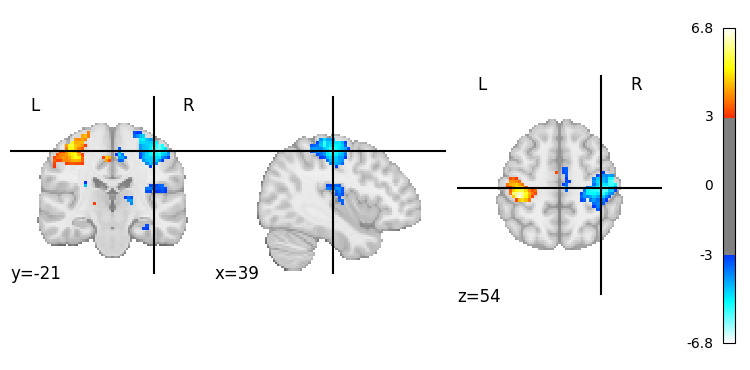

In [11]:
plotting.plot_stat_map(right_left_avg, threshold=3)

### Hypothetical group comparison

Let's say we want to compare older vs. younger adults (i.e., compare two groups). To do so, we have to specify our design matrix in a specific way. For illustration purposes, let's just assume the first 10 subject of the localizer dataset are young adults, while the latter 10 subjects are older adults.

We start by including an intercept (just as we did above)

In [12]:
design_matrix_groups = pd.DataFrame([1] * n_subjects,
                                    columns = ["intercept"],
                                    index = subject_list)

As a next step, we initialize columns that will indicate group membership. That is, we will create a new column for each group.

In [13]:
# start by initializing the group dummy columns
design_matrix_groups["group_young"] = 0
design_matrix_groups["group_old"]   = 0

In [14]:
design_matrix_groups

,intercept,group_young,group_old
sub-01,1,0,0
sub-02,1,0,0
sub-03,1,0,0
sub-04,1,0,0
sub-05,1,0,0
sub-06,1,0,0
sub-07,1,0,0
sub-08,1,0,0
sub-09,1,0,0
sub-10,1,0,0


Next, we will define the group membership. Remember that the rows of our design matrix correspond to the respective contrast maps. We know that the first 10 subjects (i.e., the first 10 contrast maps) are young adudlts, so we will set the first 10 entries of the column ```group_young``` to 1, the remaining rows will stay 0. Analogously, we set the last 10 entries of the ```group_old``` to 1.

Note: It is very important that the order of the contrast maps matches the respective entries in the design matrix (i.e., make sure that the first 10 contrast maps belong to young adults).

In [15]:
design_matrix_groups.loc[subject_list[:10], "group_young"] = 1
design_matrix_groups.loc[subject_list[10:], "group_old"] = 1

In [16]:
design_matrix_groups

,intercept,group_young,group_old
sub-01,1,1,0
sub-02,1,1,0
sub-03,1,1,0
sub-04,1,1,0
sub-05,1,1,0
sub-06,1,1,0
sub-07,1,1,0
sub-08,1,1,0
sub-09,1,1,0
sub-10,1,1,0


In [17]:
second_level = SecondLevelModel(n_jobs=2)
second_level = second_level.fit(cmaps, design_matrix = design_matrix_groups)

In practise, information regarding group membership or other participant-specific data is often stored in a separate [participants file](https://bids-specification.readthedocs.io/en/stable/03-modality-agnostic-files.html#participants-file). Thus, you would use this file to set up a second level design matrix as above.

### Define second level contrasts

Now that we have fitted the model to the data, we will have compute some contrasts in order to make inferences about the data (that is, we assign weights to our parameters). For this, we will set up a contrast matrix.

We start by defining an identity matrix (using ```np.eye```) with a shape corresponding to the number of columns in our design matrix (we could also write out the contrast vectors manually as we did in the first level analysis notebook)

In [18]:
contrast_matrix = np.eye(design_matrix_groups.shape[1])

In [19]:
contrast_matrix

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

With this contrast matrix we could test three contrasts. The first contrast (first row in the contrast matrix) would test the average effect across all subjects (intercept set to 1). The second one would test the average in the group of younger adults. Finally, the third one would test the average in the group of younger adults.

For the sake of clarity, let's define a dictionary in which we can assign a verbal label to the contrasts. Here, we will also use a list comprehension:

In [20]:
contrasts = dict(
    [(column, contrast_matrix[i]) for i, column in enumerate(design_matrix_groups.columns)]
)

In [21]:
pprint(contrasts)

{'group_old': array([0., 0., 1.]),
 'group_young': array([0., 1., 0.]),
 'intercept': array([1., 0., 0.])}


Cool, but what if we are interested in comparing younger and older adults? For this we would have to define further contrast(s).

Just as in the first level analysis we have to set one group (or condition in the 1st level) to 1 and the other one to -1. We can do this by simply subtracting the contrasts from one another:

In [22]:
contrasts['group_old-young'] =  contrasts['group_old'] - contrasts['group_young']
contrasts['group_young-old'] = -contrasts['group_old'] + contrasts['group_young']

In [23]:
pprint(contrasts)

{'group_old': array([0., 0., 1.]),
 'group_old-young': array([ 0., -1.,  1.]),
 'group_young': array([0., 1., 0.]),
 'group_young-old': array([ 0.,  1., -1.]),
 'intercept': array([1., 0., 0.])}


Now that we have defined our contrasts, we can go ahead an acutally calculate them. We will do this using a simple ```for``` loop:

In [24]:
cmaps_second = {con: None for con in contrasts}

for con in contrasts:
    print(f'\nRunning {con}...')
    print(f' - Calculating contrast...')
    res = second_level.compute_contrast(contrasts[con], output_type='z_score')
    cmaps_second[con] = res
    print( 'done.')


Running intercept...
 - Calculating contrast...
done.

Running group_young...
 - Calculating contrast...
done.

Running group_old...
 - Calculating contrast...
done.

Running group_old-young...
 - Calculating contrast...
done.

Running group_young-old...
 - Calculating contrast...
done.


### Correcting for multiple comparisons

As in the first level analysis, we need to correct for multiple comparisons in the second level analysis. Before we do so, let's have a look at the raw z-map (or: the untresholded map).

*Since the group comparisons were just hypothetical we will only look at the intercept contrast, i.e., the grand average*

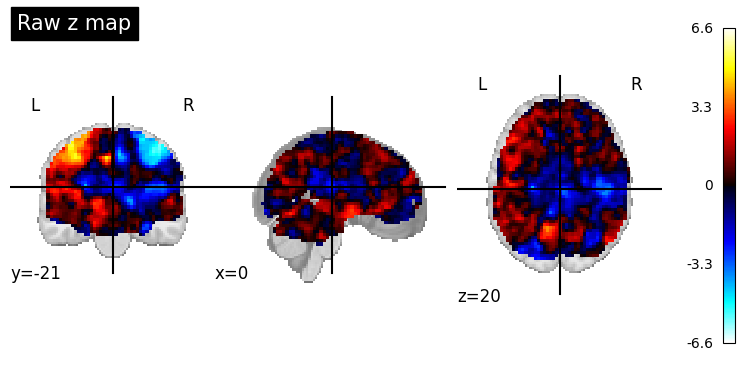

In [25]:
disp  = plotting.plot_stat_map(cmaps_second["intercept"],
                               title='Raw z map')

Now, let's correct for mulitple comparisons. As you know there are different approaches to do is. Here, we will just look at the *false discovery rate* (which doesn't mean this is the preferred approach for every research question). Specifically, we will use an alpha level of 0.05 and set the cluster-defining threshold to an arbitrary number of 10 voxels.

In [26]:
from nilearn.glm import threshold_stats_img

thresholded_map, threshold = threshold_stats_img(
    cmaps_second["intercept"],
    alpha=.05, height_control='fdr', cluster_threshold=10)

print(f"The FDR=.05 threshold is {round(threshold, 3)}")

The FDR=.05 threshold is 3.197


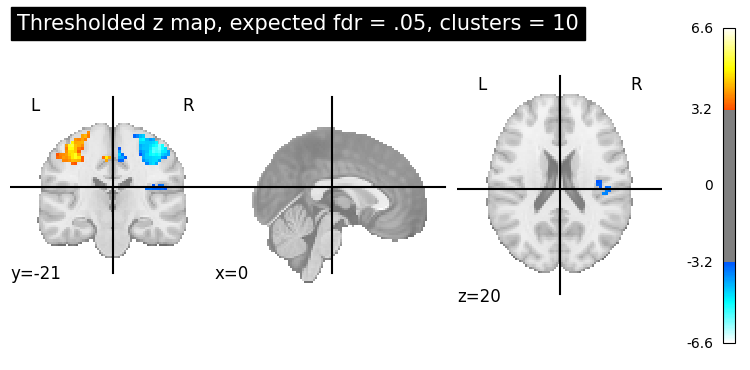

In [27]:
plotting.plot_stat_map(thresholded_map, cut_coords=disp.cut_coords,
                       title="Thresholded z map, expected fdr = .05, clusters = 10",
                       threshold=threshold)

Again, there are different approaches to correct for multiple comparisons (for example, non-parametric approches such as permutation testing are becoming more and more common). Check out the [Nilearn user guide](https://nilearn.github.io/dev/glm/second_level_model.html#multiple-comparisons-correction) to see which routines are implemented in the package.

## Store objects

Since setting up and fitting models as well computing contrasts can take some time, it would nice to be able to preserve the results of these computations (especially when working in Colab). Luckily, the ```pickle``` module from Python's standard library can help us here. It provides a way to save Python objects to files.

In [28]:
import pickle

Objects can be stored by using the ```dump``` function. All it takes is the name of the object we want to save as well as the file name (which needs to be passed to the ```open``` function; here, ```wb``` stands for "write binary")

In [29]:
pickle.dump(second_level, open("/content/second_level.pkl", "wb"))

In [30]:
!ls /content

sample_data  second_level.pkl


Next, we unpickle the object - here, we use ```rb``` (i.e., read binary) as the parameter to the ```open``` function

In [31]:
secondlvl_pkl = pickle.load(open("/content/second_level.pkl", "rb"))

After unpickling the object, we have access to the usual attributes and methods and parameters of the second level object. For example, it still contains our previously defined design matrix:

In [32]:
secondlvl_pkl.design_matrix_

,intercept,group_young,group_old
sub-01,1,1,0
sub-02,1,1,0
sub-03,1,1,0
sub-04,1,1,0
sub-05,1,1,0
sub-06,1,1,0
sub-07,1,1,0
sub-08,1,1,0
sub-09,1,1,0
sub-10,1,1,0


As we have pickled the already fitted object, we can go ahead and evaluate some contrasts (without fitting the model again):

In [33]:
right_left_pkl = secondlvl_pkl.compute_contrast(
    second_level_contrast = "intercept", output_type = "z_score")

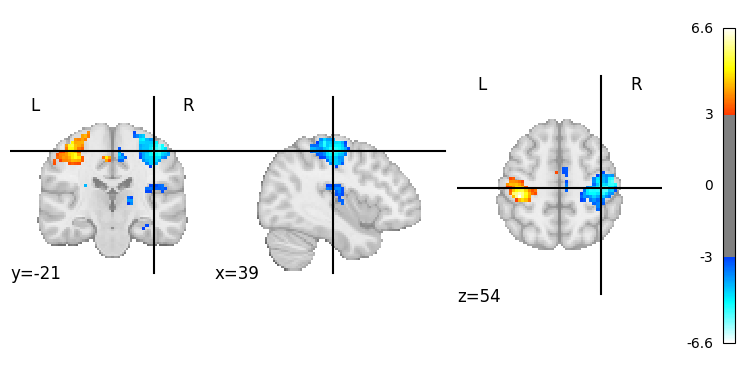

In [34]:
plotting.plot_stat_map(right_left_pkl, threshold=3)

You can also use nibabel to save your results as .nii files:

In [39]:
import nibabel as nib
nib.save(cmaps_second["intercept"], filename = "left_right_second_level.nii")

## Resources

[Nilearn user guide on second level models](https://nilearn.github.io/dev/glm/second_level_model.html#)
Here you can find links to different tutorials covering how to perform second level analyses with Nilearn. Included are (among others) overviews on:


- [Statistical testing of a second-level analysis](https://nilearn.github.io/dev/auto_examples/05_glm_second_level/plot_thresholding.html#sphx-glr-auto-examples-05-glm-second-level-plot-thresholding-py)

- [Basic one sample t test](https://nilearn.github.io/dev/auto_examples/05_glm_second_level/plot_second_level_one_sample_test.html)
  - includes different strategies for multiple comparison correction, e.g. non-parametric inference